In [1]:
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')

import itertools
import dotenv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import chromadb 
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from scipy.signal import resample
from tqdm import tqdm
import uuid

In [2]:
dotenv.load_dotenv()

True

In [3]:
chroma_client = chromadb.PersistentClient(path="DB")


In [ ]:
try: 
    chroma_client.delete_collection("my_collection_scaled")
    print("Collection deleted")
except Exception as e:
    print(e)
    pass

In [5]:
collection = chroma_client.create_collection(
    name="my_collection_scaled",
    metadata={"hnsw:space": "cosine"}
)
print("Collection created")

Collection created


In [3]:
dataset_df = pd.read_excel(os.getenv('DATASET_PATH'))
print("Data loaded")

Data loaded


In [4]:
dataset_df['Datetime'] = pd.to_datetime(dataset_df['DATE'].astype(str) + ' ' + dataset_df['TIME'].astype(str))
dataset_df = dataset_df.set_index('Datetime')


In [ ]:
dataset_df_resampled = dataset_df.resample('D').mean()

<Axes: xlabel='Datetime', ylabel='VALUE'>

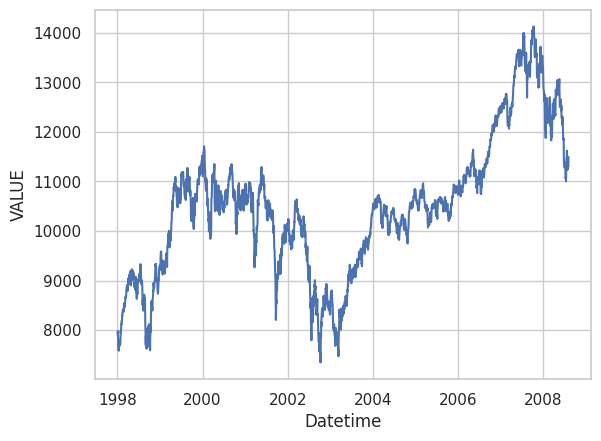

In [8]:
sns.set_theme(style="whitegrid")
sns.lineplot(x=dataset_df_resampled.index, y=dataset_df_resampled['VALUE'])

In [5]:
def chunks(iterable, batch_size=100):
    """A helper function to break an iterable into chunks of size batch_size."""
    it = iter(iterable)
    chunk = tuple(itertools.islice(it, batch_size))
    while chunk:
        yield chunk
        chunk = tuple(itertools.islice(it, batch_size))

def upsert_vectors_k(collection, df, batch_size=100, window=1000, divide=16):
    step = int(window // divide)
    data_generator = map(lambda i: {
        'id': str(df.index[i]),
        'value': list(resample(df['VALUE'][i:i+window].tolist() - np.mean(df['VALUE'][i:i+window].tolist()), 1000)),
        'metadata': {
            'ID': int(df['ID'][i]),
            'date': str(df['DATE'][i]),
            'time': str(df['TIME'][i]),
            'window': window
        }
    }, range(0, len(df['VALUE']) - window, step)) # len(df['VALUE'])

    for vectors_chunk in tqdm(chunks(data_generator, batch_size=batch_size), desc=f'Upserting vectors, window: {window}'):
        collection.upsert(
            embeddings=[v['value'] for v in vectors_chunk],
            ids=[v['id'] for v in vectors_chunk],
            metadatas=[v['metadata'] for v in vectors_chunk]
        )

In [10]:
window = 500
divide = 16

while window < len(dataset_df):
    upsert_vectors_k(collection, dataset_df, batch_size=100, window=int(window), divide=divide)
    upsert_vectors_k(collection, dataset_df, batch_size=100, window=int(window*5/4), divide=divide)
    upsert_vectors_k(collection, dataset_df, batch_size=100, window=int(window*6/4), divide=divide)
    upsert_vectors_k(collection, dataset_df, batch_size=100, window=int(window*7/4), divide=divide)
    window *= 2

Upserting vectors, window: 500: 0it [00:00, ?it/s]

Upserting vectors, window: 500: 339it [01:24,  4.01it/s]
Upserting vectors, window: 625: 269it [01:10,  3.81it/s]
Upserting vectors, window: 750: 228it [01:02,  3.62it/s]
Upserting vectors, window: 875: 195it [00:56,  3.43it/s]
Upserting vectors, window: 1000: 169it [00:58,  2.88it/s]
Upserting vectors, window: 1250: 135it [00:47,  2.86it/s]
Upserting vectors, window: 1500: 113it [00:40,  2.80it/s]
Upserting vectors, window: 1750: 97it [00:32,  3.01it/s]
Upserting vectors, window: 2000: 84it [00:28,  2.93it/s]
Upserting vectors, window: 2500: 68it [00:27,  2.51it/s]
Upserting vectors, window: 3000: 56it [00:26,  2.11it/s]
Upserting vectors, window: 3500: 48it [00:21,  2.21it/s]
Upserting vectors, window: 4000: 42it [00:21,  1.93it/s]
Upserting vectors, window: 5000: 34it [00:14,  2.28it/s]
Upserting vectors, window: 6000: 28it [00:16,  1.73it/s]
Upserting vectors, window: 7000: 24it [00:26,  1.11s/it]
Upserting vectors, window: 8000: 21it [00:10,  2.07it/s]
Upserting vectors, window: 1

In [ ]:
try: 
    chroma_client.delete_collection("rhymes")
    print("Collection deleted")
except Exception as e:
    print(e)
    pass

In [ ]:
collection = chroma_client.create_collection(
    name="rhymes",
    metadata={"hnsw:space": "euclidean"}
)
print("Collection created")

In [ ]:



def resample_non_drop(x, n):
    reflected_signal = np.concatenate((x[::-1], x, x[::-1]))
    resampled_reflected_signal = resample(reflected_signal, 3 * n)
    resampled_signal = list(resampled_reflected_signal[n:2*n])
    return resampled_signal
    

def get_differences(x, sigma=8):
    smoothed_x = gaussian_filter1d(x, sigma)
    return (smoothed_x[1:] - smoothed_x[:-1]) >= 0


def difference_process(x, window=1000, sigma=8):
    return get_differences(resample_non_drop(x, window), sigma)

def chunks_rhymes(iterable, batch_size=100):
    """A helper function to break an iterable into chunks of size batch_size."""
    it = iter(iterable)
    chunk = tuple(itertools.islice(it, batch_size))
    while chunk:
        yield chunk
        chunk = tuple(itertools.islice(it, batch_size))

def upsert_vectors_rhymes(collection, df, batch_size=100, window=1000, divide=16, sigma=8):
    step = int(window // divide)
    data_generator = map(lambda i: {
        'id': str(uuid.uuid4()),
        'value': difference_process(df['VALUE'][i:i+window].tolist(), window=window, sigma=sigma),
        'metadata': {
            'ID': int(df['ID'][i]),
            'date': str(df['DATE'][i]),
            'time': str(df['TIME'][i]),
            'window': window
        }
    }, range(0, len(df['VALUE']) - window, step)) # len(df['VALUE'])

    for vectors_chunk in tqdm(chunks_rhymes(data_generator, batch_size=batch_size), desc=f'Upserting vectors, window: {window}'):
        collection.upsert(
            embeddings=[v['value'] for v in vectors_chunk],
            ids=[v['id'] for v in vectors_chunk],
            metadatas=[v['metadata'] for v in vectors_chunk]
        )

In [48]:
window = 500
divide = 16

while window < len(dataset_df):
    upsert_vectors_k(collection, dataset_df, batch_size=100, window=int(window), divide=divide)
    upsert_vectors_k(collection, dataset_df, batch_size=100, window=int(window*5/4), divide=divide)
    upsert_vectors_k(collection, dataset_df, batch_size=100, window=int(window*6/4), divide=divide)
    upsert_vectors_k(collection, dataset_df, batch_size=100, window=int(window*7/4), divide=divide)
    window *= 2


1048575

# Search

In [8]:
sample_df = pd.read_excel('data/SAMPLE_DATASET_1SEC.xlsx', engine='openpyxl')
sample_data = sample_df.values.tolist()
sample_value = [item[1] for item in sample_data]
# assert len(sample_value) == 1000

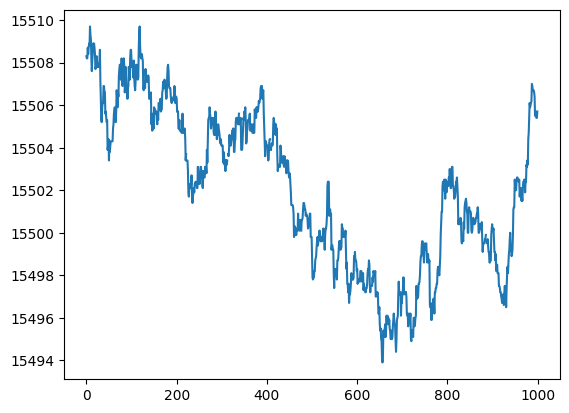

In [17]:
plt.plot(sample_value)

In [22]:
if sample_value[0] == None:
    sample_value[0] = 0

for i in range(1, 1000):
    if np.isnan(sample_value[i]):
        sample_value[i] = sample_value[i-1]

reflected_signal = np.concatenate((sample_value[::-1], sample_value, sample_value[::-1]))
resampled_reflected_signal = resample(reflected_signal, 3 * 1000)
sample_value_scaled = list(resampled_reflected_signal[1000:2000])

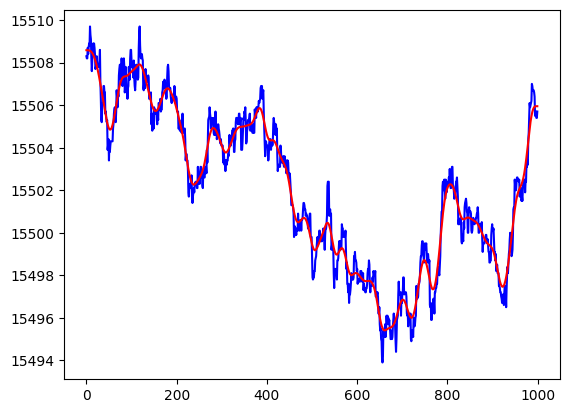

In [42]:



# Apply a Gaussian filter with a sigma of 1
sigma = 8
smoothed_data = gaussian_filter1d(sample_value, sigma)

plt.plot(sample_value, label='Original', color='blue')
plt.plot(smoothed_data, label='Smoothed', color='red')


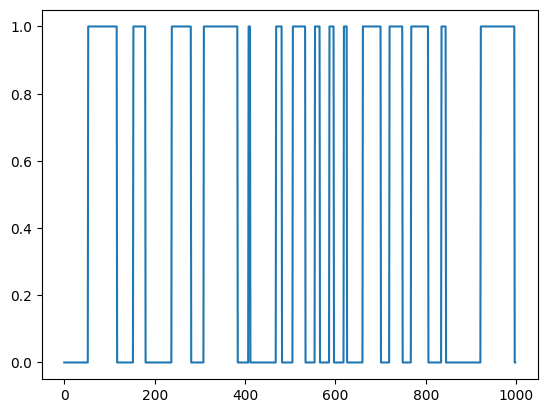

In [43]:
plt.plot(smoothed_data[1:]-smoothed_data[:-1] >= 0)

In [9]:
collection = chroma_client.get_collection(name="my_collection_scaled")

In [10]:
results = collection.query(
    query_embeddings=[sample_value_scaled],
    n_results=1
)

In [18]:
id = int(results['metadatas'][0][0]['ID'])
distance = results['distances'][0][0]
window = results['metadatas'][0][0]['window']

embedding = dataset_df['VALUE'][id:id+window].tolist()
embedding_mean = np.mean(embedding)
embedding_norm = np.linalg.norm(embedding - embedding_mean)

resampled_window_reflected_signal = resample(reflected_signal, 3 * window)
sample = resampled_window_reflected_signal[window:2*window]
sample = sample - np.mean(sample)
# sample = resample(sample_value, window)
# sample[0] = sample_value[0]
# sample[-1] = sample_value[-1]
# sample = sample - np.mean(sample)

# nor_embedding = np.array(embedding)/np.linalg.norm(np.array(embedding))
scaled_sample = sample/np.linalg.norm(sample)*embedding_norm + embedding_mean

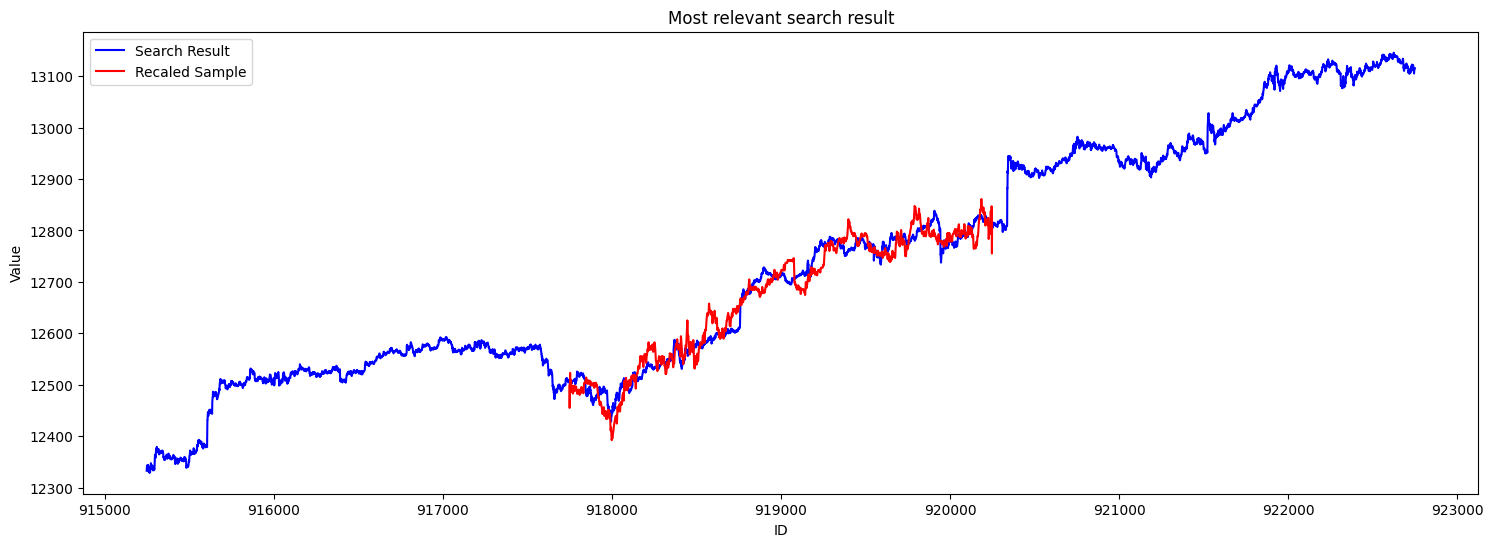

In [19]:
start = max(0, id - window)
end = min(len(dataset_df['VALUE']), id + window * 2)

plot_ids = np.arange(start, end)

# plt.plot(dataset_df.index[start:end], dataset_df['VALUE'][start:end], color='blue', label='Search Result')
# plt.plot(dataset_df.index[id:id+window], scaled_sample, color='red', label='sample')
plt.figure(figsize=(18, 6))
plt.plot(np.arange(start, end), dataset_df['VALUE'][start:end], color='blue', label='Search Result')
plt.plot(np.arange(id, id+window), scaled_sample, color='red', label='Recaled Sample')
plt.title("Most relevant search result")
plt.xlabel("ID")
plt.ylabel("Value")
plt.legend()

In [18]:
print("Distance score: ", distance)
print("Start Datetime: ", dataset_df.index[id])
print("End Datetime: ", dataset_df.index[id+window])
print("Window: ", window)

Distance score:  0.9997804164886475
Start Datetime:  1999-09-15 10:27:00
End Datetime:  1999-09-17 09:47:00
Window:  750
